# **19ECE311 COMPUTER NETWORKS**  
## Self-Healing Networks: AI-Based Solutions for Fault Detection and Recovery  

---

**By**  
- **Charan U** $~~~~~~~~~~$ (CB.EN.U4ECE22111)  
- **Daejuswaram G** $~$ (CB.EN.U4ECE22115)  
- **Mohan Kumar D** $~$(CB.EN.U4ECE22132)  

---


### Network Simulation

In [1]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import pandas as pd
import time

def create_network(num_nodes=20, connectivity_prob=0.2):

    # Create a random graph with given probability of edge creation
    G = nx.erdos_renyi_graph(num_nodes, connectivity_prob)

    while not nx.is_connected(G):
        # Add edges until the graph is connected
        components = list(nx.connected_components(G))
        if len(components) > 1:
            # Connect two random nodes from different components
            comp1 = random.choice(list(components[0]))
            comp2 = random.choice(list(components[1]))
            G.add_edge(comp1, comp2)

    # Add attributes to nodes and edges
    for node in G.nodes():
        G.nodes[node]['status'] = 'normal'  # Node status: normal or faulty
        G.nodes[node]['load'] = random.uniform(0.1, 0.5)  # CPU load
        G.nodes[node]['memory'] = random.uniform(0.1, 0.5)  # Memory usage
        G.nodes[node]['packet_drop'] = random.uniform(0.0, 0.01)  # Packet drop rate

    for edge in G.edges():
        G.edges[edge]['status'] = 'normal'  # Link status: normal or faulty
        G.edges[edge]['bandwidth'] = random.uniform(100, 1000)  # Mbps
        G.edges[edge]['latency'] = random.uniform(1, 10)  # ms
        G.edges[edge]['packet_loss'] = random.uniform(0.0, 0.01)  # Packet loss probability

    return G


### Visualization of the Network

In [2]:
def visualize_network(G, title="Network Topology"):

    plt.figure(figsize=(12, 8))

    node_colors = ['red' if G.nodes[node]['status'] == 'faulty' else 'green' for node in G.nodes()]

    edge_colors = ['red' if G.edges[edge]['status'] == 'faulty' else 'black' for edge in G.edges()]

    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


### Update Network State

In [3]:
def update_network_state(G):

    for node in G.nodes():
        # Update node attributes
        if G.nodes[node]['status'] == 'normal':
            # Simulate random fluctuations in load and memory usage
            G.nodes[node]['load'] = max(0.0, min(1.0, G.nodes[node]['load'] + random.uniform(-0.05, 0.05)))
            G.nodes[node]['memory'] = max(0.0, min(1.0, G.nodes[node]['memory'] + random.uniform(-0.05, 0.05)))
            G.nodes[node]['packet_drop'] = max(0.0, min(1.0, G.nodes[node]['packet_drop'] + random.uniform(-0.01, 0.01)))
        else:
            # Faulty nodes may degrade further
            G.nodes[node]['packet_drop'] = min(1.0, G.nodes[node]['packet_drop'] + random.uniform(0.01, 0.05))

    for edge in G.edges():
        # Update edge attributes
        if G.edges[edge]['status'] == 'normal':
            # Simulate random fluctuations in bandwidth and latency
            G.edges[edge]['bandwidth'] = max(50, min(1000, G.edges[edge]['bandwidth'] + random.uniform(-10, 10)))
            G.edges[edge]['latency'] = max(1, min(50, G.edges[edge]['latency'] + random.uniform(-1, 1)))
            G.edges[edge]['packet_loss'] = max(0.0, min(1.0, G.edges[edge]['packet_loss'] + random.uniform(-0.01, 0.01)))
        else:
            # Faulty edges may degrade further
            G.edges[edge]['packet_loss'] = min(1.0, G.edges[edge]['packet_loss'] + random.uniform(0.01, 0.05))


### Network Simulation

In [4]:
def simulate_network_behavior(G, time_steps=100, fault_prob=0.05):

    telemetry_data = []

    for t in range(time_steps):
        # Randomly introduce faults with a certain probability
        if random.random() < fault_prob:
            introduce_fault(G)

        # Collect telemetry data from all nodes and edges
        time_data = collect_telemetry(G, t)
        telemetry_data.extend(time_data)

        # Update network state (load, traffic, etc.)
        update_network_state(G)

    return telemetry_data

def introduce_fault(G):

    fault_type = random.choice(['node_failure', 'link_failure', 'congestion', 'packet_loss'])

    if fault_type == 'node_failure':
        # Select a random node to fail
        node = random.choice(list(G.nodes()))
        G.nodes[node]['status'] = 'faulty'
        G.nodes[node]['packet_drop'] = random.uniform(0.5, 1.0)  # High packet drop rate
        print(f"Node {node} failure introduced")

    elif fault_type == 'link_failure':
        # Select a random edge to fail
        if G.edges():
            edge = random.choice(list(G.edges()))
            G.edges[edge]['status'] = 'faulty'
            G.edges[edge]['packet_loss'] = random.uniform(0.5, 1.0)  # High packet loss
            print(f"Link {edge} failure introduced")

    elif fault_type == 'congestion':
        # Select a random edge to congest
        if G.edges():
            edge = random.choice(list(G.edges()))
            G.edges[edge]['status'] = 'faulty'
            G.edges[edge]['latency'] = random.uniform(50, 100)  # High latency
            print(f"Congestion on link {edge} introduced")

    elif fault_type == 'packet_loss':
        # Select a random node with high packet loss
        node = random.choice(list(G.nodes()))
        G.nodes[node]['status'] = 'faulty'
        G.nodes[node]['packet_drop'] = random.uniform(0.1, 0.3)  # Moderate packet drop
        print(f"Packet loss at node {node} introduced")


### Telemetry Data Collection

In [5]:
def collect_telemetry(G, timestep):

    data = []

    # Collect node telemetry
    for node in G.nodes():
        node_data = {
            'timestep': timestep,
            'element_type': 'node',
            'element_id': node,
            'status': 1 if G.nodes[node]['status'] == 'normal' else 0,  # Binary status
            'load': G.nodes[node]['load'],
            'memory': G.nodes[node]['memory'],
            'packet_drop': G.nodes[node]['packet_drop'],
            'degree': G.degree(node),
            'fault': 1 if G.nodes[node]['status'] == 'faulty' else 0  # Label for ML
        }
        data.append(node_data)

    # Collect edge telemetry
    for u, v in G.edges():
        edge_data = {
            'timestep': timestep,
            'element_type': 'link',
            'element_id': f"{u}-{v}",
            'status': 1 if G.edges[(u, v)]['status'] == 'normal' else 0,  # Binary status
            'bandwidth': G.edges[(u, v)]['bandwidth'],
            'latency': G.edges[(u, v)]['latency'],
            'packet_loss': G.edges[(u, v)]['packet_loss'],
            'node1_load': G.nodes[u]['load'],
            'node2_load': G.nodes[v]['load'],
            'fault': 1 if G.edges[(u, v)]['status'] == 'faulty' else 0  # Label for ML
        }
        data.append(edge_data)

    return data


### SVM based Fault Detection

In [6]:
def prepare_data(telemetry_data, element_type='node'):

    # Filter data by element type
    filtered_data = [d for d in telemetry_data if d['element_type'] == element_type]

    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame(filtered_data)

    # Define features based on element type
    if element_type == 'node':
        features = ['load', 'memory', 'packet_drop', 'degree']
    else:  # link
        features = ['bandwidth', 'latency', 'packet_loss', 'node1_load', 'node2_load']

    # Extract features and target
    X = df[features].values
    y = df['fault'].values

    return X, y, features

def train_svm_model(X, y):

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create and train SVM model
    model = SVC(kernel='rbf', probability=True)
    model.fit(X_train_scaled, y_train)

    # Evaluate model
    y_pred = model.predict(X_test_scaled)
    print("SVM Model Evaluation:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return model, scaler


### CNN based Fault Detection

In [7]:
def prepare_sequence_data(telemetry_data, element_type='node', sequence_length=10):

    # Filter data by element type
    filtered_data = [d for d in telemetry_data if d['element_type'] == element_type]

    # Convert to DataFrame
    df = pd.DataFrame(filtered_data)

    # Define features based on element type
    if element_type == 'node':
        features = ['load', 'memory', 'packet_drop', 'degree']
    else:  # link
        features = ['bandwidth', 'latency', 'packet_loss', 'node1_load', 'node2_load']

    # Group by element_id and create sequences
    sequences = []
    labels = []

    for element_id, group in df.groupby('element_id'):
        group = group.sort_values('timestep')

        # Create sequences
        for i in range(len(group) - sequence_length):
            seq = group.iloc[i:i+sequence_length][features].values
            label = group.iloc[i+sequence_length]['fault']

            sequences.append(seq)
            labels.append(label)

    # Convert to numpy arrays
    X = np.array(sequences)
    y = np.array(labels)

    return X, y

def train_cnn_model(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    seq_length, n_features = X_train.shape[1], X_train.shape[2]

    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(seq_length, n_features)),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"CNN Model Evaluation: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")

    return model


### Recovery Functions

In [8]:
def isolate_node(G, node):

    # Get all neighbors of the node
    neighbors = list(nx.neighbors(G, node))

    # Remove edges connecting the node to its neighbors
    for neighbor in neighbors:
        if G.has_edge(node, neighbor):
            G.remove_edge(node, neighbor)

    print(f"Node {node} isolated from the network.")


def reroute_around_node(G, node):

    neighbors = list(nx.neighbors(G, node))

    for neighbor in neighbors:
        # Find a path from the neighbor to another node, avoiding the faulty node
        try:
            # Find a target node that is not the faulty node or the current neighbor
            target = next(n for n in G.nodes() if n != node and n != neighbor)

            # Find the shortest path from the neighbor to the target node, avoiding the faulty node
            path = nx.shortest_path(G, source=neighbor, target=target)

            # If a path is found, print the path
            print(f"Rerouted traffic from {neighbor} to {target} via path: {path}")

        except nx.NetworkXNoPath:
            print(f"No alternative path found for {neighbor} avoiding {node}.")
        except StopIteration:
            print(f"No suitable target found for rerouting from {neighbor}.")


def adjust_traffic(G, u, v):

    # Get the neighbors of the nodes u and v
    neighbors_u = list(nx.neighbors(G, u))
    neighbors_v = list(nx.neighbors(G, v))

    # Adjust traffic on links connected to node u
    for neighbor in neighbors_u:
        if neighbor != v and G.has_edge(u, neighbor):
            # Increase bandwidth of the link
            G.edges[(u, neighbor)]['bandwidth'] = min(1000, G.edges[(u, neighbor)]['bandwidth'] * 1.1)  # Increase by 10%
            print(f"Adjusted traffic: Increased bandwidth on link ({u}, {neighbor})")

    # Adjust traffic on links connected to node v
    for neighbor in neighbors_v:
        if neighbor != u and G.has_edge(v, neighbor):
            # Increase bandwidth of the link
            G.edges[(v, neighbor)]['bandwidth'] = min(1000, G.edges[(v, neighbor)]['bandwidth'] * 1.1)  # Increase by 10%
            print(f"Adjusted traffic: Increased bandwidth on link ({v}, {neighbor})")
def find_alternative_path(G, u, v):

    # Create a copy of the graph to avoid modifying the original
    G_copy = G.copy()

    # Remove the direct edge between u and v if it exists
    if G_copy.has_edge(u, v):
        G_copy.remove_edge(u, v)

    try:
        # Find the shortest path between u and v in the modified graph
        path = nx.shortest_path(G_copy, source=u, target=v)
        return path
    except nx.NetworkXNoPath:
        # If no path exists, return None
        return None


### Recovery Mechanisms

In [9]:
def detect_faults(G, node_model, node_scaler, link_model, link_scaler):

    detected_faults = []

    # Check nodes for faults
    for node in G.nodes():
        # Extract node features
        features = np.array([[
            G.nodes[node]['load'],
            G.nodes[node]['memory'],
            G.nodes[node]['packet_drop'],
            G.degree(node)
        ]])

        # Scale features
        scaled_features = node_scaler.transform(features)

        # Predict fault probability
        fault_prob = node_model.predict_proba(scaled_features)[0][1]

        # If probability is high, mark as detected fault
        if fault_prob > 0.7:
            detected_faults.append(('node', node, fault_prob))

    # Check links for faults
    for u, v in G.edges():
        # Extract link features
        features = np.array([[
            G.edges[(u, v)]['bandwidth'],
            G.edges[(u, v)]['latency'],
            G.edges[(u, v)]['packet_loss'],
            G.nodes[u]['load'],
            G.nodes[v]['load']
        ]])

        # Scale features
        scaled_features = link_scaler.transform(features)

        # Predict fault probability
        fault_prob = link_model.predict_proba(scaled_features)[0][1]

        # If probability is high, mark as detected fault
        if fault_prob > 0.7:
            detected_faults.append(('link', (u, v), fault_prob))

    return detected_faults

def recover_network(G, detected_faults):

    recovery_actions = []

    for fault_type, element, prob in detected_faults:
        if fault_type == 'node':

            # Node recovery strategies
            # Strategy 1: Isolate the faulty node
            isolate_node(G, element)
            recovery_actions.append(f"Isolated node {element}")

            # Strategy 2: Reroute traffic around the node
            reroute_around_node(G, element)
            recovery_actions.append(f"Rerouted traffic around node {element}")

            # Strategy 3: Activate backup if available
            if random.random() < 0.3:  # Simulate successful recovery with 30% probability
                G.nodes[element]['status'] = 'normal'
                G.nodes[element]['packet_drop'] = random.uniform(0.0, 0.01)
                recovery_actions.append(f"Node {element} restored to normal operation")

        elif fault_type == 'link':
            u, v = element

            # Strategy 1: Find alternative path
            alternative_path = find_alternative_path(G, u, v)
            if alternative_path:
                recovery_actions.append(f"Found alternative path between {u} and {v}: {alternative_path}")

            # Strategy 2: Adjust traffic on other links to compensate
            adjust_traffic(G, u, v)
            recovery_actions.append(f"Adjusted traffic to compensate for faulty link between {u} and {v}")

            # Strategy 3: Repair link if possible
            if G.has_edge(u, v) and random.random() < 0.4:  # Check if edge exists
                G.edges[(u, v)]['status'] = 'normal'
                G.edges[(u, v)]['latency'] = random.uniform(1, 10)
                G.edges[(u, v)]['packet_loss'] = random.uniform(0.0, 0.01)
                recovery_actions.append(f"Link between {u} and {v} restored to normal operation")

    return recovery_actions


### Dataset Generation

In [10]:
def generate_realistic_dataset(num_samples=1000, fault_ratio=0.2):

    data = []

    # Generate normal samples
    normal_samples = int(num_samples * (1 - fault_ratio))
    for i in range(normal_samples):
        sample = {
            'timestamp': i,
            'node_id': f"node_{random.randint(1, 100)}",
            'load': random.uniform(0.1, 0.6),  # Normal CPU load
            'memory': random.uniform(0.1, 0.7),  # Normal memory usage
            'packet_drop': random.uniform(0.0, 0.03),  # Low packet drop rate
            'latency': random.uniform(1, 15),  # Normal latency
            'throughput': random.uniform(80, 100),  # Normal throughput (%)
            'error_rate': random.uniform(0.0, 0.02),  # Low error rate
            'status': 'normal',
            'fault': 0  # No fault
        }
        data.append(sample)

    # Generate faulty samples
    fault_samples = int(num_samples * fault_ratio)
    for i in range(fault_samples):
        fault_type = random.choice(['high_load', 'memory_leak', 'packet_loss', 'high_latency'])

        if fault_type == 'high_load':
            sample = {
                'timestamp': i + normal_samples,
                'node_id': f"node_{random.randint(1, 100)}",
                'load': random.uniform(0.8, 1.0),  # High CPU load
                'memory': random.uniform(0.1, 0.7),  # Normal memory usage
                'packet_drop': random.uniform(0.0, 0.03),  # Low packet drop rate
                'latency': random.uniform(1, 15),  # Normal latency
                'throughput': random.uniform(60, 80),  # Reduced throughput
                'error_rate': random.uniform(0.0, 0.02),  # Low error rate
                'status': 'faulty',
                'fault': 1  # Fault present
            }
        elif fault_type == 'memory_leak':
            sample = {
                'timestamp': i + normal_samples,
                'node_id': f"node_{random.randint(1, 100)}",
                'load': random.uniform(0.1, 0.6),  # Normal CPU load
                'memory': random.uniform(0.8, 1.0),  # High memory usage
                'packet_drop': random.uniform(0.0, 0.03),  # Low packet drop rate
                'latency': random.uniform(1, 15),  # Normal latency
                'throughput': random.uniform(60, 80),  # Reduced throughput
                'error_rate': random.uniform(0.0, 0.02),  # Low error rate
                'status': 'faulty',
                'fault': 1  # Fault present
            }
        elif fault_type == 'packet_loss':
            sample = {
                'timestamp': i + normal_samples,
                'node_id': f"node_{random.randint(1, 100)}",
                'load': random.uniform(0.1, 0.6),  # Normal CPU load
                'memory': random.uniform(0.1, 0.7),  # Normal memory usage
                'packet_drop': random.uniform(0.1, 0.5),  # High packet drop rate
                'latency': random.uniform(1, 15),  # Normal latency
                'throughput': random.uniform(40, 60),  # Low throughput
                'error_rate': random.uniform(0.05, 0.2),  # High error rate
                'status': 'faulty',
                'fault': 1  # Fault present
            }
        elif fault_type == 'high_latency':
            sample = {
                'timestamp': i + normal_samples,
                'node_id': f"node_{random.randint(1, 100)}",
                'load': random.uniform(0.1, 0.6),  # Normal CPU load
                'memory': random.uniform(0.1, 0.7),  # Normal memory usage
                'packet_drop': random.uniform(0.0, 0.03),  # Low packet drop rate
                'latency': random.uniform(50, 200),  # High latency
                'throughput': random.uniform(40, 60),  # Low throughput
                'error_rate': random.uniform(0.02, 0.1),  # Moderate error rate
                'status': 'faulty',
                'fault': 1  # Fault present
            }

        data.append(sample)

    # Convert to DataFrame and shuffle
    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)  # Shuffle the data

    return df


### Evaluation and Performance Metrics

In [11]:
def evaluate_self_healing(G, time_steps=50, fault_prob=0.1):

    # Generate initial telemetry data for training models
    print("Generating training data...")
    training_data = simulate_network_behavior(G, time_steps=200, fault_prob=0.05)

    # Prepare data and train models
    print("Training node fault detection model...")
    X_node, y_node, _ = prepare_data(training_data, element_type='node')
    node_model, node_scaler = train_svm_model(X_node, y_node)

    print("Training link fault detection model...")
    X_link, y_link, _ = prepare_data(training_data, element_type='link')
    link_model, link_scaler = train_svm_model(X_link, y_link)

    # Prepare sequence data for CNN (optional)
    print("Preparing sequence data for CNN...")
    X_seq_node, y_seq_node = prepare_sequence_data(training_data, element_type='node')
    X_seq_link, y_seq_link = prepare_sequence_data(training_data, element_type='link')


### Main function

Creating network topology...


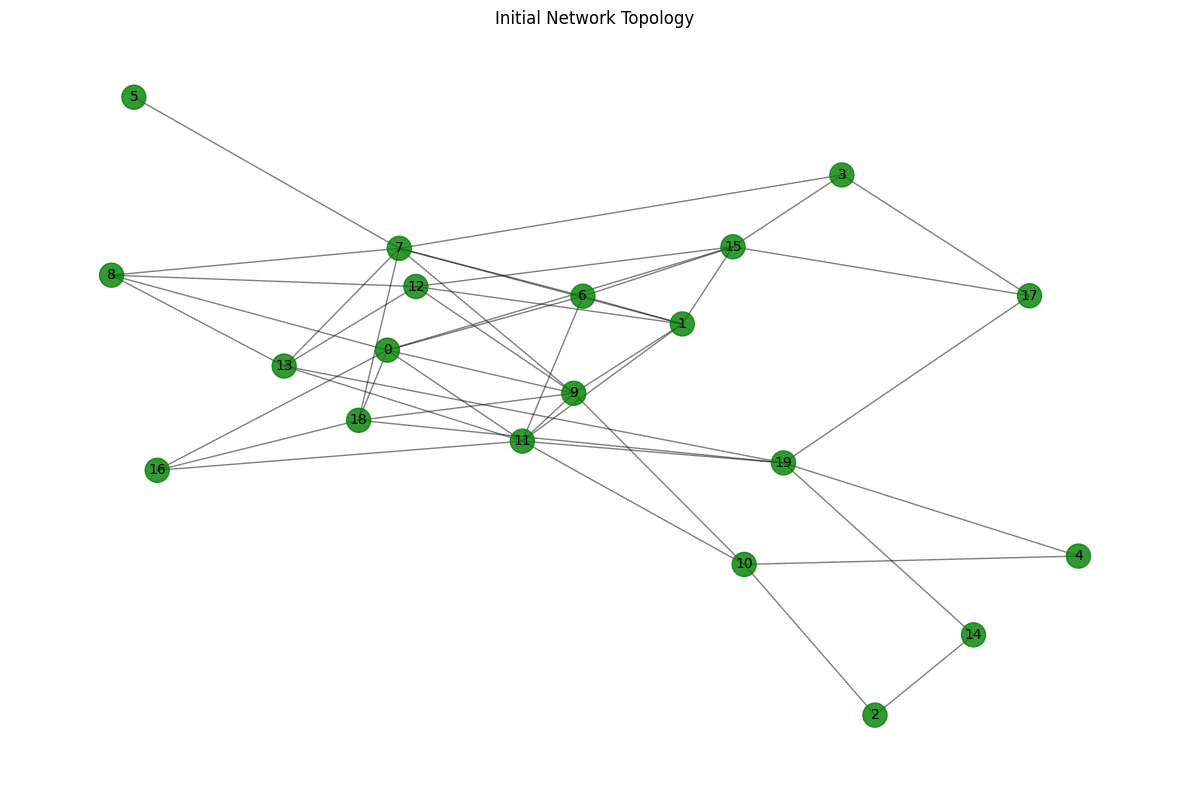

Simulating network behavior...
Packet loss at node 16 introduced
Congestion on link (0, 15) introduced
Node 17 failure introduced
Node 3 failure introduced
Congestion on link (9, 12) introduced
Node 0 failure introduced
Node 14 failure introduced
Link (1, 11) failure introduced
Node 6 failure introduced
Link (16, 18) failure introduced
Node 8 failure introduced
Packet loss at node 10 introduced
Link (1, 11) failure introduced
Packet loss at node 0 introduced
Preparing data for node fault detection...
Training SVM model for node fault detection...
SVM Model Evaluation:
[[328   0]
 [  0  72]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       328
           1       1.00      1.00      1.00        72

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

Preparing data for link fault detection...
Training SVM model for link faul

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7766 - loss: 0.4984 - val_accuracy: 0.8507 - val_loss: 0.2974
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8799 - loss: 0.3486 - val_accuracy: 0.9722 - val_loss: 0.1701
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9746 - loss: 0.1601 - val_accuracy: 0.9722 - val_loss: 0.1088
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9756 - loss: 0.1186 - val_accuracy: 0.9826 - val_loss: 0.0855
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9814 - loss: 0.0850 - val_accuracy: 0.9861 - val_loss: 0.0778
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9863 - loss: 0.0712 - val_accuracy: 0.9861 - val_loss: 0.0780
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9893 - loss: 0.0604 - val_accuracy: 0.9861 - val_loss: 0.0728
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9804 - loss: 0.0759 - val_accuracy: 0.9722 - val_loss

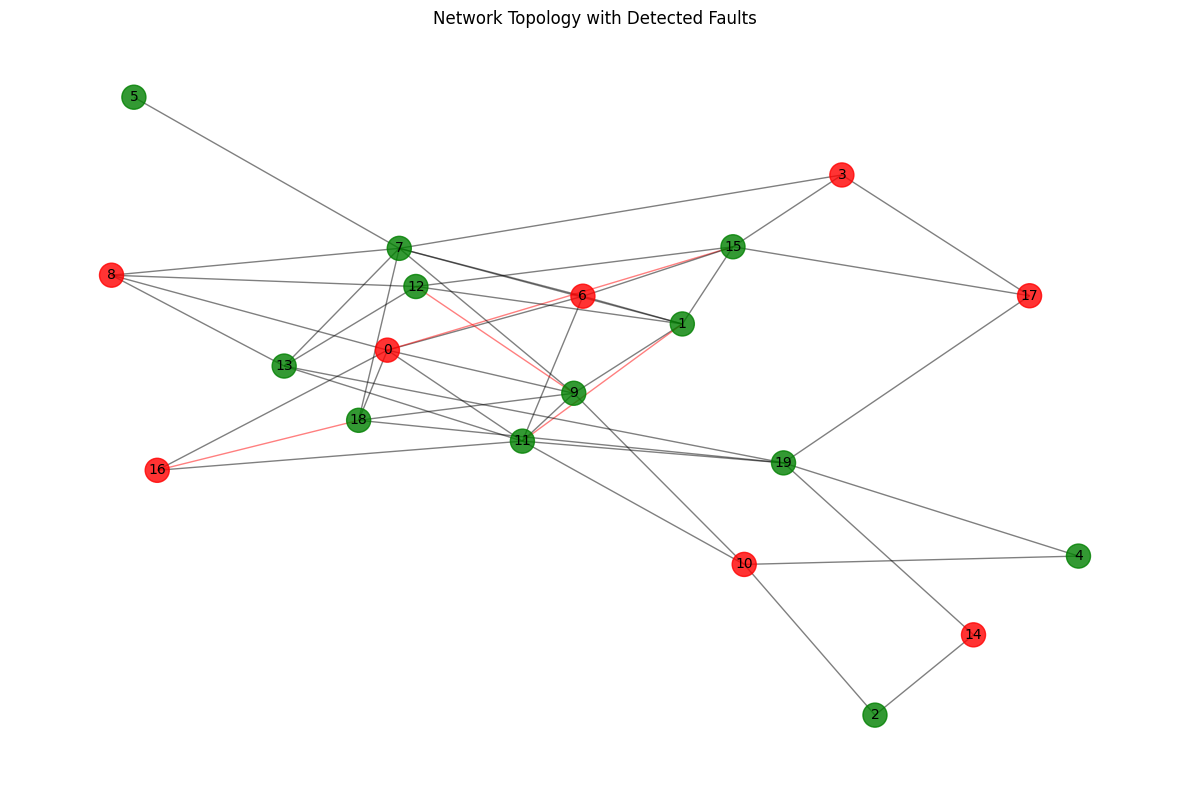

Recovering from detected faults...
Node 0 isolated from the network.
Node 3 isolated from the network.
Node 6 isolated from the network.
Node 8 isolated from the network.
Node 10 isolated from the network.
Node 14 isolated from the network.
Node 16 isolated from the network.
Node 17 isolated from the network.
Adjusted traffic: Increased bandwidth on link (15, 1)
Adjusted traffic: Increased bandwidth on link (15, 12)
Adjusted traffic: Increased bandwidth on link (1, 7)
Adjusted traffic: Increased bandwidth on link (1, 9)
Adjusted traffic: Increased bandwidth on link (1, 12)
Adjusted traffic: Increased bandwidth on link (1, 15)
Adjusted traffic: Increased bandwidth on link (11, 9)
Adjusted traffic: Increased bandwidth on link (11, 13)
Adjusted traffic: Increased bandwidth on link (11, 19)
Adjusted traffic: Increased bandwidth on link (9, 1)
Adjusted traffic: Increased bandwidth on link (9, 7)
Adjusted traffic: Increased bandwidth on link (9, 11)
Adjusted traffic: Increased bandwidth on l

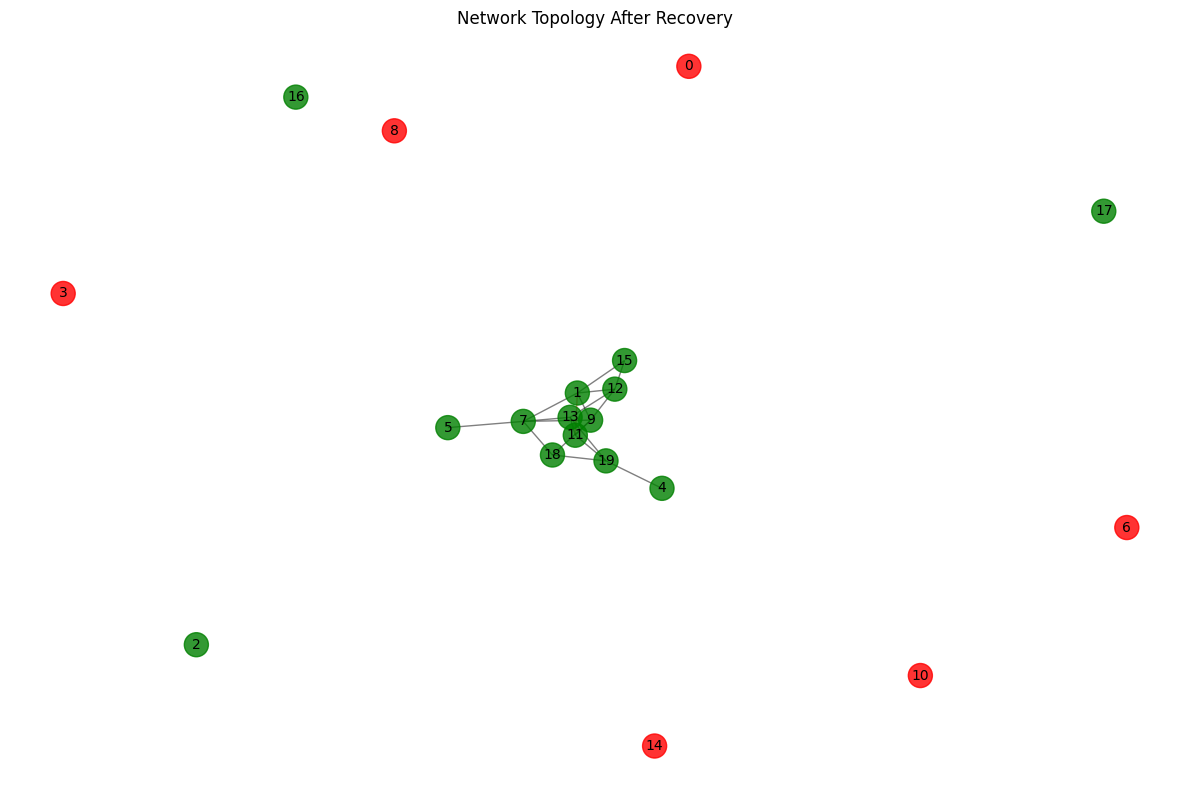

In [12]:
def main():

    # Step 1: Create a network topology
    print("Creating network topology...")
    G = create_network(num_nodes=20, connectivity_prob=0.3)
    visualize_network(G, title="Initial Network Topology")

    # Step 2: Simulate network behavior and collect telemetry data
    print("Simulating network behavior...")
    telemetry_data = simulate_network_behavior(G, time_steps=100, fault_prob=0.1)

    # Step 3: Prepare data for SVM
    print("Preparing data for node fault detection...")
    X_node, y_node, node_features = prepare_data(telemetry_data, element_type='node')
    print("Training SVM model for node fault detection...")
    node_model, node_scaler = train_svm_model(X_node, y_node)

    print("Preparing data for link fault detection...")
    X_link, y_link, link_features = prepare_data(telemetry_data, element_type='link')
    print("Training SVM model for link fault detection...")
    link_model, link_scaler = train_svm_model(X_link, y_link)

    # Step 4: Prepare sequential data for CNN
    print("Preparing sequential data for CNN models...")
    X_seq_node, y_seq_node = prepare_sequence_data(telemetry_data, element_type='node')
    X_seq_link, y_seq_link = prepare_sequence_data(telemetry_data, element_type='link')

    print("Training CNN model for node fault detection...")
    cnn_node_model = train_cnn_model(X_seq_node, y_seq_node)

    print("Training CNN model for link fault detection...")
    cnn_link_model = train_cnn_model(X_seq_link, y_seq_link)

    # Step 5: Detect faults using trained models
    print("Detecting faults in the network...")
    detected_faults = detect_faults(G, node_model, node_scaler, link_model, link_scaler)

    if detected_faults:
        print(f"Detected Faults: {detected_faults}")
        visualize_network(G, title="Network Topology with Detected Faults")

        # Step 6: Recover from detected faults
        print("Recovering from detected faults...")
        recovery_actions = recover_network(G, detected_faults)
        for action in recovery_actions:
            print(action)

        visualize_network(G, title="Network Topology After Recovery")

    else:
        print("No faults detected in the network.")

if __name__ == "__main__":
    main()
